# Disease map


Similar to tissue_map v2.4

In [1]:
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

from owlready2 import onto_path, get_ontology
import pandas as pd
import re
import spacy
import xml.sax
import csv
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer

ModuleNotFoundError: No module named 'owlready2'

In [2]:
# Load the ontology and create a dictionary of classes and synonyms

onto_path.append('../../data/ontologies/')
onto = get_ontology('https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/refs/heads/main/src/ontology/HumanDO.owl').load()


def preprocess(input_str):
    punct_pattern = r'\ *[_&<>:-]+\ *'
    input_str = re.sub(punct_pattern, ' ', input_str)
    return input_str.lower().strip()


classes = {c.name: c.label.first() for c in onto.classes()}
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()} 

# remove all acronyms with likley collisions
# acronym_blacklist = ['COLD', 'DISH', 'ALL', 'CAN', 'GO', 'FEB', 'MARCH', 'WED', 'MOD', 'PCA']
# for acronym in acronym_blacklist:
#     class_synonyms = {id: [val for val in synonyms if val != acronym] for id, synonyms in class_synonyms.items()}

# Remove generic terms to avoid false positives
# Cancer
del classes['DOID_162']
del class_synonyms['DOID_162']
# Disease
del classes['DOID_4']
del class_synonyms['DOID_4']
# Syndrome
del classes['DOID_225']
del class_synonyms['DOID_225']

class_synonyms['DOID_14221'] += ['metabolic syndrome'] # missing synonym available on website
class_synonyms['DOID_2945'] += ['sars', 'cov'] # common lowercased synonyms

# create a reverse mapping of classes and synonyms to BTO IDs
classes_reverse = {preprocess(c.label.first()): c.name for c in onto.classes() if c.label != []}
class_synonyms_reverse = {preprocess(s): c for c, syn in class_synonyms.items() for s in syn}
labels_reverse = {**classes_reverse, **class_synonyms_reverse}

assert len(classes) == len(class_synonyms)
print('Number of classes:', len(classes))

# flatten the synonyms and class labels into a single set
class_labels = {c for c in classes.values() if c is not None}
class_synonyms_flattend = {s for syn in class_synonyms.values() for s in syn}
onto_values = class_labels.union(class_synonyms_flattend)

Number of classes: 14155


In [3]:
# creates a spacy matcher to match patterns of ontology terms and synonyms
#  - patterns are created by tokenizing the ontology terms and synonyms
#  - matcher looks at only direct matches

nlp = spacy.load('en_core_web_lg')

# include the ontology values in the vocabulary
for value in onto_values:
    nlp.vocab.strings.add(value)

matcher = Matcher(nlp.vocab)
tokenizer = Tokenizer(nlp.vocab)

for onto_value in onto_values:
    patterns = []
    # Handle acronyms: keep the original case to avoid false positives with common words
    if onto_value.isupper() and len(onto_value) <= 12:
        patterns.append([{'TEXT': token.text } for token in tokenizer(str(onto_value))])
    else:
        patterns.append([{'LOWER': token.lower_} for token in tokenizer(str(onto_value))])
    
    # 'FUZZY' matching: too slow
    # patterns.append([{'LOWER': {'FUZZY2': token.lower_}} for token in tokenizer(str(onto_value))])
    match_id = nlp.vocab.strings[str(onto_value)]
    matcher.add(match_id, patterns, greedy='LONGEST')

In [4]:
# reverse mapping removes redundant end terms from the key where possible
redundant_end_terms = ('disease', 'syndrome', 'cancer')
additional_labels = {}
for key, value in labels_reverse.items():
    if key.endswith(redundant_end_terms):
        # add the key without the redundant end term
        additional_labels[' '.join(key.split()[:-1])] = value

for key, value in additional_labels.items():
    if key not in labels_reverse:
        labels_reverse[key] = value
        nlp.vocab.strings.add(key)

matcher_attr = Matcher(nlp.vocab)
# # standard tokenizer from spacy
# tokenizer_attr = Tokenizer(nlp.vocab)

patterns = []
for label in labels_reverse.keys():
    if label == '':
        continue
    patterns = []
    if onto_value.isupper() and len(onto_value) <= 12:
        patterns.append([{'TEXT': token.text } for token in tokenizer(str(onto_value))])
    else:
        patterns.append([{'LOWER': token.lower_} for token in tokenizer(str(onto_value))])

    match_id = nlp.vocab.strings[str(onto_value)]
    matcher_attr.add(match_id, patterns, greedy='LONGEST')


In [66]:
class BioSamplesMatcherHandler(xml.sax.ContentHandler):
    '''
    SAX handler class to read in information from a BioSamples XML file
        - Reads the title, paragraph, and attributes of each BioSample
        - Information stored in the provided sample_dict with the biosample_id as the key
    '''
    def __init__(self, sample_dict) -> None:
        super().__init__()
        self.sample_dict = sample_dict
        self.attribute_dict = {}
        self.biosample_id = ''
        self.content_dict = {}
        self.is_title = False
        self.is_paragraph = False
        self.attribute_name = ''

    def startElement(self, name, attrs):
        if name == 'BioSample':
            self.biosample_id = attrs['accession']
        elif name == 'Title':
            self.is_title = True
        elif name == 'Paragraph':
            self.is_paragraph = True
        elif name == 'Attribute':
            try:
                self.attribute_name = attrs['harmonized_name']
            except KeyError:
                self.attribute_name = attrs['attribute_name']

    def characters(self, content):
        if self.is_title:
            self.content_dict['title'] = content.lower()
            self.is_title = False
        elif self.is_paragraph:
            self.content_dict['paragraph'] = content.lower()
            self.is_paragraph = False
        elif self.attribute_name != '':
            self.attribute_dict[self.attribute_name] = content.lower()
            self.attribute_name = ''
        

    def endElement(self, name):
        if name == 'BioSample':
            self.content_dict['attributes'] = self.attribute_dict
            self.sample_dict[self.biosample_id] = self.content_dict
            self.attribute_dict = {}
            self.content_dict = {}
    
    def endDocument(self):
        print('Finished parsing BioSamples XML file')

In [75]:
sample_dict = {}
biosamples_path = '../../data/biosamples/biosample_random_samples.xml'
# biosamples_path = '../../data/biosamples/biosample_set.699.xml'
# biosamples_path = '../../data/biosamples/biosample_set.012.xml'


parser = xml.sax.make_parser()
handler = BioSamplesMatcherHandler(sample_dict)
parser.setContentHandler(handler)

parser.parse(biosamples_path)
print('Number of samples:', len(sample_dict))

Finished parsing BioSamples XML file
Number of samples: 10000


In [79]:
import json

numbers_pattern = r'^[\d\. ]*$'
punct_pattern = r'\ *[_&<>:-]+\ *'

def not_onto_term(content_str):
    not_onto_terms = { 
        'not provided', 'not applicable', 'not collected', 'not available', 'none', 'undetected', 'unknown', 'none detected', 'na', 'missing', 'no', 'yes', 'n/a', 'true', 'false', 'public',
    }
    if re.match(numbers_pattern, content_str):
        return True
    if content_str in not_onto_terms:
        return True
    if len(content_str) < 3:
        return True
    return False


def not_onto_attribute(attribute):
    institution_terms = { 'institute', 'institute', 'center', 'laboratory', 'lab', 'submitter', 'submitter_handle', 'facility', 'unit', 'broker', 'department', 'division', 'group', 'service', 'company', 'corporation', 'organization', 'association', 'lab', 'facilities', 'collected_by', 'collected by' }
    if any(term in attribute.lower() for term in institution_terms):
        return True


def not_case_study_positive(attribute, term):
    # check if attributes contain 'subject is affected' and value is not negative
    if attribute == 'subject_is_affected':
        if term in {'no', 'false', 'negative', 'not affected', 'not positive', '0', 'n', 'f' }:
            return False
    return True


with open('biosamples_random_content.jsonl', 'w') as f:
    for biosample_id, content in sample_dict.items():
        if 'title' in content:
            term = re.sub(punct_pattern, " ", content['title'])
            if not_onto_term(term):
                continue
            content_dict = {'text': term, 'meta': {'source': 'title', 'biosample_id': biosample_id}}
            f.write(json.dumps(content_dict) + '\n')
        if 'paragraph' in content:
            term = re.sub(punct_pattern, " ", content['paragraph'])
            if not_onto_term(term):
                continue
            content_dict = {'text': term, 'meta': {'source': 'paragraph', 'biosample_id': biosample_id}}
            f.write(json.dumps(content_dict) + '\n')
        if 'attributes' in content:
            for attribute in content['attributes']:
                if not_onto_attribute(attribute):
                    continue
                term = re.sub(punct_pattern, " ", content['attributes'][attribute])
                if not_case_study_positive(attribute, term):
                    continue
                if not_onto_term(term):
                    continue
                content_dict = {'text': term, 'meta': {'source': 'attribute:' + attribute, 'biosample_id': biosample_id}}
                f.write(json.dumps(content_dict) + '\n')


In [77]:
# adds a regex pattern to the default tokenizer to split on underscores
infixes = nlp.Defaults.infixes + [r'[_~]']
infix_re = spacy.util.compile_infix_regex(infixes)
tokenizer.infix_finditer = infix_re.finditer

In [78]:
# finds all returned matches from the matcher
# - matcher looks at the title, paragraph, and attributes
# - returns a dictionary of matches for each sample

#TODO: should load sample_dict from previous jsonl files
# jsonl was used to split by lines, instead use dask/df partitions

matches_dict = {}
confident_attributes = {'disease', 'host disease', 'host_disease', 'study disease', 'study_disease', 'disease state', 'disease_state', 'disease status', 'disease_status', 'disease type', 'disease_type', 'disease subtype', 'disease_subtype' }

for biosample_id, content_dict in sample_dict.items():
    cur_matches = {}
    title = content_dict.get('title', '')
    attributes = content_dict.get('attributes','')

    title_tokens = tokenizer(title)
    attributes_tokens = {key: tokenizer(value) for key, value in attributes.items()}

    title_matches = matcher(title_tokens, as_spans=True)
    attribute_matches = {}
    
    for key, value in attributes_tokens.items():
        attribute_match = matcher(value, as_spans=True)
        if len(attribute_match) > 0:
            attribute_matches[key] = matcher(value, as_spans=True)

    if len(title_matches) > 0:
        cur_matches['title'] = title_matches

    if len(attribute_matches) > 0:
        cur_matches['attributes'] = attribute_matches

    if 'paragraph' in content_dict:
        paragraph = content_dict['paragraph']
        paragraph_tokens = tokenizer(paragraph)
        paragraph_matches = matcher(paragraph_tokens, as_spans=True)
        
        if len(paragraph_matches) > 0:
            cur_matches['paragraph'] = paragraph_matches

    # # Skip: if no matches found, use alternative weak matcher 
    # if cur_matches == {}:
    #     for key, value in attributes_tokens.items():
    #         if key not in confident_attributes:
    #             continue
    #         attribute_match = matcher_attr(value, as_spans=True)
    #         if len(attribute_match) > 0:
    #             cur_matches[key] = attribute_match

    #     if len(attribute_matches) > 0:
    #         cur_matches['attributes'] = attribute_matches
            
    matches_dict[biosample_id] = cur_matches

AttributeError: 'str' object has no attribute 'items'

In [62]:
positive_samples = {key: value for key, value in matches_dict.items() if len(value) > 0}
negative_samples = {key: value for key, value in matches_dict.items() if len(value) == 0}
print('Number of positive results:', len(positive_samples))
print('Number of negative results:', len(negative_samples))
print('Percentage of positive results:', len(positive_samples) / (len(positive_samples) + len(negative_samples)))
# 0.4581 with redundant terms
# 0.4575 without redundant terms
# exclude generic terms like 'disease' and 'cancer'
# blacklist: excluding negative controls: 0.448
# whitelist: only including positive controls for Case-Control
# remove generic labels: 'disease' and 'cancer': 0.433
# remove all acronyms: 0.33
# remove only conflicting acronyms: 0.41
# use alt pattern for acronyms: 0.18

Number of positive results: 1749
Number of negative results: 7946
Percentage of positive results: 0.18040226921093347


In [65]:
# Write to csv file

def write_row(writer, row):
    writer.writerow(row)

with open('../../data/biosamples/results/biosample_disease_locations_1.0.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['biosample_accession_id', 'biosample_url', 'source', 'text', 'DO_ID', 'DO_label'])
    for biosample_id, matches in matches_dict.items():
        source = ''
        text = ''
        do_id = ''
        do_label = ''
        biosample_url = f'https://www.ncbi.nlm.nih.gov/biosample/{biosample_id} '

        for match_type, match in matches.items():
            if match_type == 'attributes':
                for attribute, match in match.items():
                    if attribute == 'submitter_handle':
                        print('submitter_handle')
                        print(match, match_type, attribute, biosample_id)
                    source = f'attribute:{attribute}'
                    terms = set([token.text for token in match])
                    text = ' '.join(terms)
                    label = match[0].label_
                    do_id = labels_reverse.get(preprocess(label), '')
                    do_label = classes.get(do_id, '')
                    writer.writerow([biosample_id, biosample_url, source, text, do_id, do_label])
            if match_type == 'title':
                source = 'title'
                text = ' '.join([token.text for token in match])
                label = match[0].label_
                do_id = labels_reverse.get(preprocess(label), '')
                do_label = classes.get(do_id, '')
                writer.writerow([biosample_id, biosample_url, source, text, do_id, do_label])
            if match_type == 'paragraph':
                source = 'paragraph'
                text = ' '.join([token.text for token in match])
                label = match[0].label_
                do_id = labels_reverse.get(preprocess(label), '')
                do_label = classes.get(do_id, '')
                writer.writerow([biosample_id, biosample_url, source, text, do_id, do_label])

df = pd.read_csv('../../data/biosamples/results/biosample_disease_locations_1.0.csv')
# sort the results by source (attribute, paragraph, title) per biosample
df = df.groupby('biosample_accession_id').apply(lambda x: x.sort_values('source', ascending=True)).reset_index(drop=True)
df.to_csv('../../data/biosamples/results/biosample_disease_locations_1.0.csv', index=False)

print('Finished writing results to CSV file')

submitter_handle
[glaucoma] attributes submitter_handle SAMN00499634
submitter_handle
[glaucoma] attributes submitter_handle SAMN00499737
submitter_handle
[glaucoma] attributes submitter_handle SAMN00502231
submitter_handle
[nephropathy] attributes submitter_handle SAMN00774500
submitter_handle
[schizophrenia] attributes submitter_handle SAMN00786622
submitter_handle
[schizophrenia] attributes submitter_handle SAMN00787356
submitter_handle
[autism] attributes submitter_handle SAMN00855029
submitter_handle
[melanoma] attributes submitter_handle SAMN02361566
submitter_handle
[influenza] attributes submitter_handle SAMN02411087
submitter_handle
[myasthenia gravis] attributes submitter_handle SAMN02720565
submitter_handle
[myasthenia gravis] attributes submitter_handle SAMN02720768
submitter_handle
[lung disease] attributes submitter_handle SAMN02807589
submitter_handle
[lung disease] attributes submitter_handle SAMN02807706
submitter_handle
[metabolic syndrome] attributes submitter_handle

DO_label
severe acute respiratory syndrome     589
influenza                             362
diabetes mellitus                     106
tuberculosis                           78
prostate cancer                        73
                                     ... 
follicular thyroid carcinoma            1
focal segmental glomerulosclerosis      1
familial melanoma                       1
esophageal cancer                       1
vulvovaginal candidiasis                1
Name: count, Length: 245, dtype: int64


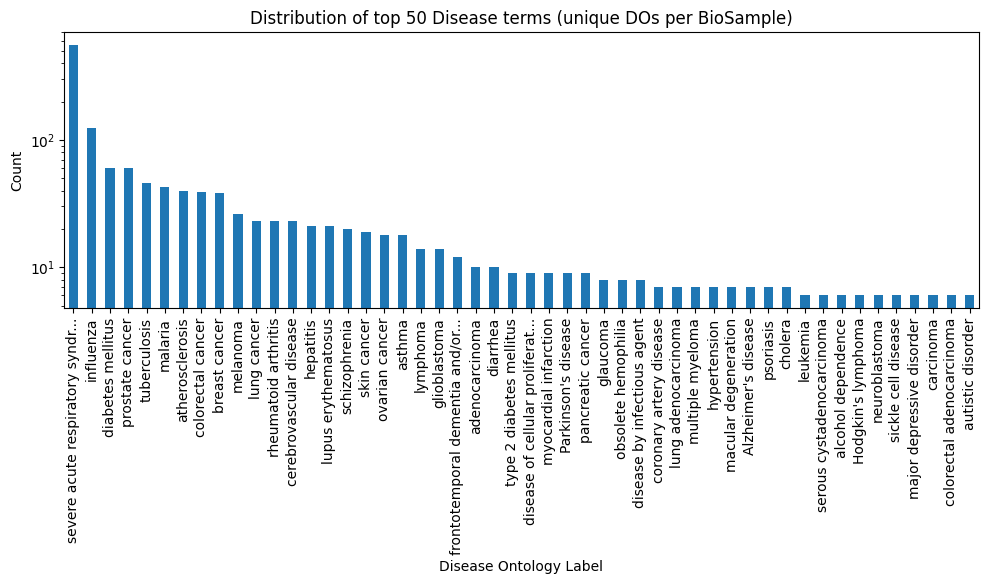

In [64]:
# plot the distribution of the number of matches
import matplotlib.pyplot as plt

df = pd.read_csv('../../data/biosamples/results/biosample_disease_locations_1.0.csv')
print(df.value_counts('DO_label'))
# plot_data = df.drop_duplicates(subset='biosample_accession_id', keep='first')

# group by biosample and do_id, only keep the first unique value
plot_data = df.groupby(['biosample_accession_id', 'DO_label']).first().reset_index()


# plot the distribution of the DO_label
plt.figure(figsize=(10, 8))

top_k = 50
top_100 = plot_data['DO_label'].value_counts().head(top_k)
top_100.plot(kind='bar')

plt.xlabel('Disease Ontology Label')
plt.ylabel('Count')
plt.title(f'Distribution of top {top_k} Disease terms (unique DOs per BioSample)')
# rotate the x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# log scale 
plt.yscale('log')
# limit x label to 20 chars
plt.gca().set_xticklabels([
    f'{label[:30]}...' 
    if len(label) > 30 
    else label
    for label in top_100.index
])

plt.show()

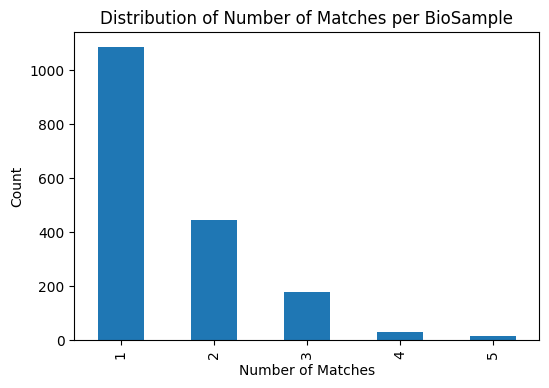

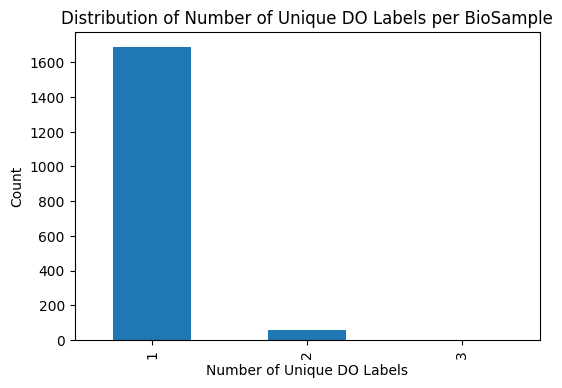

In [61]:
# count number of matches per biosample
df = pd.read_csv('../../data/biosamples/results/biosample_disease_locations_1.0.csv')

plt.figure(figsize=(6, 4))
df.groupby('biosample_accession_id').size().value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Matches')
plt.ylabel('Count')
plt.title('Distribution of Number of Matches per BioSample')
plt.show()

# count number of unique DO labels per biosample
plt.figure(figsize=(6, 4))
df.groupby('biosample_accession_id')['DO_ID'].nunique().value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Unique DO Labels')
plt.ylabel('Count')
plt.title('Distribution of Number of Unique DO Labels per BioSample')
plt.show()

In [53]:
test = tokenizer('CDC SARS CoV2 Sequencing Baseline Constellation')
matches = matcher(test, as_spans=True)
print(dir(matches[0]))
print(matches[0].label)

['_', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_fix_dep_copy', '_vector', '_vector_norm', 'as_doc', 'char_span', 'conjuncts', 'doc', 'end', 'end_char', 'ent_id', 'ent_id_', 'ents', 'get_extension', 'get_lca_matrix', 'has_extension', 'has_vector', 'id', 'id_', 'kb_id', 'kb_id_', 'label', 'label_', 'lefts', 'lemma_', 'n_lefts', 'n_rights', 'noun_chunks', 'orth_', 'remove_extension', 'rights', 'root', 'sent', 'sentiment', 'sents', 'set_extension', 'similarity', 'start', 'start_char', 'subtree', 'tensor', 'text', 'text_with_ws', 'to_array', 'vector', 'vector_norm', 'vocab']
12622501317362276795


In [13]:
# get all acronyms in synonyms
class_synonyms = {c.name: c.hasExactSynonym + c.hasRelatedSynonym for c in onto.classes()} 
acronyms = {id: [val for val in synonyms if val.isupper() == True] for id, synonyms in class_synonyms.items()}
acronyms = {k: v for k, v in acronyms.items() if v}
acronyms = [val for sublist in acronyms.values() for val in sublist]
acronyms = [val for val in acronyms if len(val) == 12]
print(acronyms)
# Ask chatgpt to find acronyms with collisions to regular terms

['BLS, TYPE I', 'SLC35A1-CDG', 'TMEM165-CDG', 'SLC35A2-CDG', 'SLC39A8-CDG', 'CCDC115-CDG', 'TMEM199-CDG', 'PDE-ALDH7A1', 'SMARCA4-DTS', 'DFNA6/14/38']
